## Bike Share Regression
The [bikeshare dataset](https://www.kaggle.com/contactprad/bike-share-daily-data) offers us a nice opportunity to try out a regression scenario by predicting bike rentals, taking into account a variety of timeseries and other quantitative featues in the dataset. There are hourly and daily datasets available but for this example we'll work with the hourly one. This assignment was originally included in the [Udacity Deep Learning Nano-Degree](
https://www.udacity.com/course/deep-learning-nanodegree--nd101) where you coded the whole neural net part from scratch with numpy to understand in detail how each step works. If you've landed here because you need help with that assignment you've come to the wrong place as this notebook won't give anything away! This version implements the full PyTorch functionality within a [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) wrapper. I really like how this neatens up your code and takes the burden of coding up those long training loops out of the equation, while still giving you a lot of flexibility when developing your model!

### Viewing the data

In [1]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib ipympl

In [2]:
# And then import and view the data
df = pd.read_csv('bike_sharing_hourly.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# Being a timeseries problem, let's look at the date ranges we have available
print(f"""Earliest date - {df['dteday'].min()} 
Latest date - {df['dteday'].max()}
Total number of days - {len(df) / 24}""")

Earliest date - 2011-01-01 
Latest date - 2012-12-31
Total number of days - 724.125


<AxesSubplot:xlabel='dteday'>

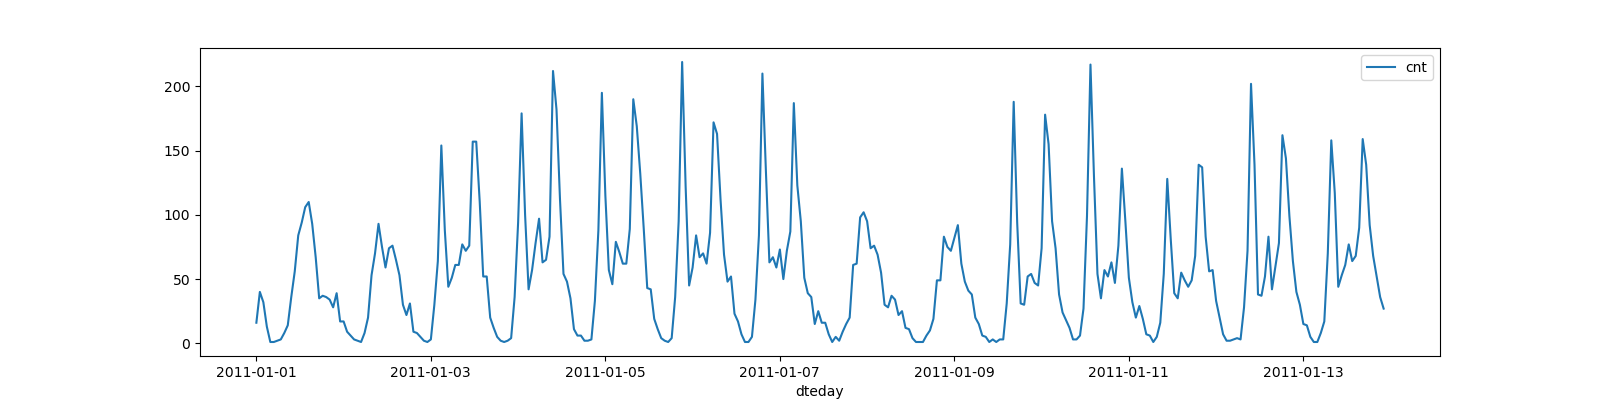

In [4]:
# We'll be predicting cnt which is the total number of bikeshares per hour, 
# so let's have a look at that target variable for the first 14 days
df[df['dteday'].isin(df['dteday'].unique()[0:14])].plot(x='dteday', y='cnt', figsize=(16, 4))
# 1 & 2 January 2011 and 8 & 9 January 2011 were weekends - one can immediately see
# the correlation with day of week and how that changes the demand

### Preparing the data in general
This section acknowledges [Udacity](https://www.udacity.com/course/deep-learning-nanodegree--nd101), the preparation recipe is theirs.

By looking at the <b>Dataset characteristics</b> described at Kaggle, and by viewing the data fields in more detail, we find that 'season', 'mnth', 'hr', 'holiday', 'weekday' and 'weathersit' are all categorical variables.

#### Categorical variables: one-hot encoding
A column like weathersit actually contains 4 possible values, 1 through 4, each of which represents a different set of weather conditions. Instead of representing this data as 1 feature with 4 values, it works better if we represent if as 4 binary features. This process is known as one-hot encoding and is nicely explained by Chris Albon [here](https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_nominal_categorical_features/). Note that 'holiday' is effectively already one-hot encoded as it either has a value 0 for 'not a holiday' or 1 for 'is a holiday'.

In [5]:
onehot_fields = ['season', 'mnth', 'hr', 'weekday', 'weathersit']
for field in onehot_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(onehot_fields, axis = 1)
df.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,1,1,0,0,0
1,2,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,1,1,0,0,0
2,3,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,1,1,0,0,0
3,4,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,1,1,0,0,0
4,5,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,1,1,0,0,0


#### Continuous variables: scaling
It is common practice to scale the continuous variables, i.e. to standardize them on a zero mean with a standard deviation of 1. We do this even for 'cnt' which is our target variable, and therefore we need to be able to get back again to get an actual number of bikes predicted so we'll save away the various means and standard deviations for converting back later.

In [6]:
continuous_fields = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for field in continuous_fields:
    mean, std = df[field].mean(), df[field].std()
    scaled_features[field] = [mean, std]
    df.loc[:, field] = (df[field] - mean)/std
scaled_features

{'casual': [35.67621842453536, 49.305030387053186],
 'registered': [153.78686920996606, 151.35728591258317],
 'cnt': [189.46308763450142, 181.38759909186527],
 'temp': [0.4969871684216586, 0.19255612124972407],
 'hum': [0.6272288394038822, 0.1929298340629125],
 'windspeed': [0.1900976063064631, 0.12234022857279413]}

#### Data we won't use

In [7]:
df.columns

Index(['instant', 'dteday', 'yr', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt', 'season_1',
       'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4'],
      dtype='object')

In [8]:
# Create a backup of df before we drop these fields - we'll need this later to plot our testing data
df_backup = df.copy()

fields_to_drop = ['instant', 'dteday', 'atemp', 'workingday']
df.drop(fields_to_drop, axis=1, inplace = True)
df.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,1,1,0,0,0


### Preparing the data for training

#### Train / test / validation split
This is a timeseries problem, so it would be typical to train on the earlier data, and test / validate on the later data.

In [9]:
# Split of 60 days of data from the end of the df for validation
validation_data = df[-60*24:]
df = df[:-60*24]

# Split of 21 days of data from the end of the df for testing
test_data = df[-21*24:]
df = df[:-21*24]

# The remaining (earlier) data will be used for training
train_data = df

# What have we ended up with?
print(f'''Validation data length: {len(validation_data)}
Test data length: {len(test_data)}
Train data length: {len(train_data)}''')

Validation data length: 1440
Test data length: 504
Train data length: 15435


In [10]:
# Separate the data into feature and target fields
target_fields = ['cnt', 'casual', 'registered']

train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(target_fields, axis=1), validation_data[target_fields]

### Defining the model and hyperparameters
Before proceeding with this section, I'd recommend taking a look at the PyTorch Lightning [INTRODUCTION GUIDE](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html) which describes how each section of the LightningModule template contributes and fits together. You'll recognize the same components that you're used to in PyTorch, but they are organized into functions with specific naming conventions that need to be adhered to.

In [11]:
# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler

In [12]:
l_rate = 0.2
mse_loss = nn.MSELoss(reduction = 'mean')

In [13]:
class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 as we have 56 features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(56, 10)
        self.fc2 = nn.Linear(10, 1)
    
    # Question: how should the forward pass be performed, and what will its ouputs be?
    # Perform the forward pass
    # We're using the sigmoid activation function on our hidden layer, but our output layer has no activation 
    # function as we're predicting a continuous variable so we want the actual number predicted
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### The Data Loaders ###     
    
    # Question: How do you want to load your data into the model?
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[['cnt']].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(), torch.tensor(validation_targets[['cnt']].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 128)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[['cnt']].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 128)
        return test_loader

### The Optimizer ### 

    # Question: what optimizer will I use?
    # Define optimizer function: here we are using Stochastic Gradient Descent
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 

    # Question: what should a training step look like?
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    
    # Question: what should a validation step look like?
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     

    # Question: what should a test step look like?
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [14]:
model = Regression()
trainer = Trainer(max_epochs = 50)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 570   
1 | fc2  | Linear | 11    
--------------------------------
581       Trainable params
0         Non-trainable params
581       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [15]:
# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []
trainer.test()

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\BikeSharing\lightning_logs\version_2\checkpoints\epoch=49-step=6050.ckpt
Loaded model weights from checkpoint at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\BikeSharing\lightning_logs\version_2\checkpoints\epoch=49-step=6050.ckpt
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 

Testing: 0it [00:00, ?it/s]

[{}]

In [41]:
predictions_actual[1].size()

torch.Size([128, 1])

In [16]:
# Here I'm getting the mean and standard deviation values for 'cnt', so I can convert my predicted
# values back to actual numbers of bike rides again, instead of the scaled values used to predict on
mean = scaled_features['cnt'][0]
std = scaled_features['cnt'][1]

In [17]:
# Get dates for plotting
datesx = list(df_backup[-21*24:]['dteday'])

# Get predicted points (scaled back to their original size)
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[0] * std + mean)

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[0] * std + mean)   

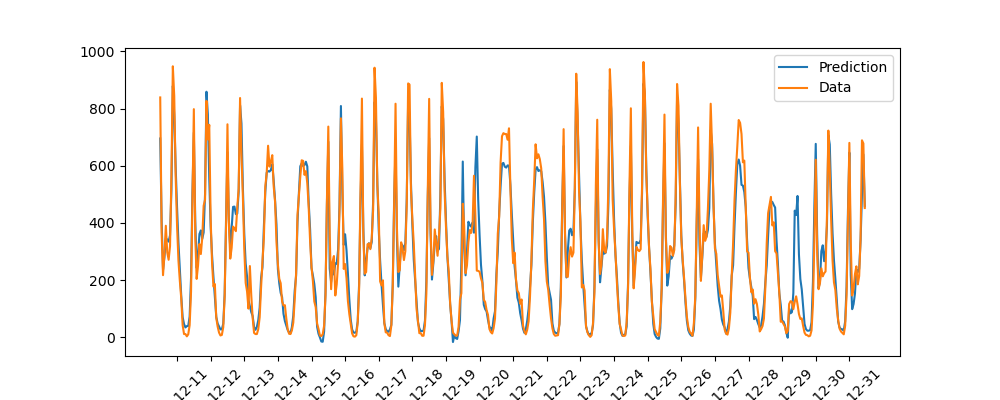

In [18]:
# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(plot_pred, label='Prediction')
ax.plot(plot_actual, label='Data')
ax.set_xticks(np.arange(len(datesx))[12::24])
ax.set_xticklabels(datesx[12::24], rotation=45)
ax.legend()

In [27]:
# The tensorboard logger is pretty nifty too!
#%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [24]:
%reload_ext tensorboard